## In this notebook, you will learn principally how to use
 
- ImageDataGenerator,
- Differents Pretrained Models


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Libraries

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

# Preparing the Dataset

In [ ]:
# Let's create a function to see some images 

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        if len(images)>3:
            break
    fig=plt.figure(figsize=(10,12))
    xrange=range(1,5)
    
    for img,x in zip(images,xrange):
        ax=fig.add_subplot(2,2,x)
        ax.imshow(img)
        ax.set_title(img.shape)

In [ ]:
load_images_from_folder("../input/surface-crack-detection/Positive")

In [ ]:
load_images_from_folder("../input/surface-crack-detection/Negative")

In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

## 1. Inception V3 

https://www.kaggle.com/keras/inceptionv3

Inception-v3 is a convolutional neural network that is 48 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 299-by-299.

In [ ]:
# You have to add Inception V3 files from 
# file--> add or upload data-->search by URL--> https://www.kaggle.com/keras/inceptionv3
!ls /kaggle/input


In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/kaggle/input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
     layer.trainable = False
        
# Print the model summary
# pre_trained_model.summary()

In [ ]:
# We will use the part of the pre_trained model from input later until the layer 'mixed7'
# You can also choose different layer for starting
last_layer = pre_trained_model.get_layer('mixed7') 
last_output = last_layer.output

#Then we add our layers 

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout layer to prevent overfitting
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x)
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
    
model.summary()

In [ ]:
# Create Data Generator
# Split data train-validation sets by using validation_split=0.3
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory('../input/surface-crack-detection',
                                                     target_size=(150,150),
                                                     batch_size=64,
                                                     shuffle=True,
                                                     class_mode='binary',
                                                     subset='training')            


In [ ]:
validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

validation_generator =  validation_datagen.flow_from_directory('../input/surface-crack-detection',
                                                                target_size=(150,150),
                                                                batch_size=64,
                                                                class_mode='binary',
                                                                subset='validation')          
                                       

In [ ]:
callbacks = myCallback()

history = model.fit_generator(train_generator,
            validation_data = validation_generator,
            epochs = 4,
            verbose = 1,
            callbacks=[callbacks])

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

### How to Save a Model
- Since training can take a long time when building deep learning models, it is always a good idea to save your model once the training is complete if you believe you will be using the model again later.

In [ ]:
!pwd

In [ ]:
model.save('/kaggle/working/Crack_Detection_InceptionV3_model.h5')

### How to Load a Model

In [ ]:
!ls /kaggle/working

In [ ]:
# load model
from keras.models import load_model

model_inception = load_model('Crack_Detection_InceptionV3_model.h5')
# summarize model.
model_inception.summary()

In [35]:
model_inception.layers

In [36]:
len(model_inception.layers)

233

In [73]:
from keras.preprocessing import image
img1 = image.load_img('../input/test-pchloro/cracking-in-concrete (1).jpg',target_size=(150,150))

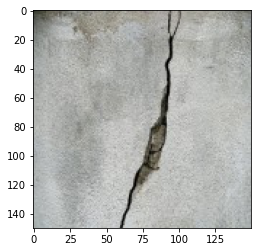

In [74]:
plt.imshow(img1)

In [75]:
img2=image.img_to_array(img1)
img2=img2/255

In [76]:
img2=np.expand_dims(img2,[0])
print(img2.shape)

(1, 150, 150, 3)


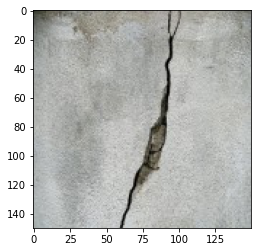

In [77]:
plt.imshow(img1)

In [78]:
pred = model_inception.predict(img2)

In [79]:
# prediction score (for cracked)
print(pred)

[[1.]]
